In [14]:
import requests
import json
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.linear_model import LinearRegression
import plotly.express as px
import polyfit

In [15]:
#Calling the Data

data = ['TSLA', 'AAPL', 'MSFT', 'SBUX', 'EBAY', 'ETSY', 'DIS','PYPL','ABNB','MCD','JNJ', 'BA', 'NDX', '^GSPC']
compmarket_tickers = ['NDX']

start_date = "2018-01-01"
end_date = "2023-07-21"

stock_adjclose= pd.DataFrame()

stocks_adjclose= yf.download(data, start=start_date, end=end_date)["Adj Close"]

stock_beta = []

for i in data: 
      stock_beta.append(yf.Ticker(i).info)
      
      

[*********************100%***********************]  14 of 14 completed


In [16]:
#Loading Market Data

market_return = pd.read_csv('Market Return - Sheet1.csv', index_col='Date')
market_return.index = pd.to_datetime(market_return.index)
market_return = market_return.loc['2018-01-01':'2023-05-31']
market_return.head()

,Mkt_RF,RF
Date,,
2018-01-02,0.85,0.01
2018-01-03,0.59,0.01
2018-01-04,0.42,0.01
2018-01-05,0.66,0.01
2018-01-08,0.19,0.01


In [17]:
stock_beta= pd.DataFrame(stock_beta)

stock_beta= stock_beta[['symbol', 'beta']]

stock_beta

,symbol,beta
0,TSLA,NaN
1,AAPL,1.292349
2,MSFT,0.910860
3,SBUX,0.927937
4,EBAY,1.359289
5,ETSY,1.984289
6,DIS,1.280054
7,PYPL,1.315573
8,ABNB,1.215015
9,MCD,0.643442


In [18]:
# Normalize stock data based on initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

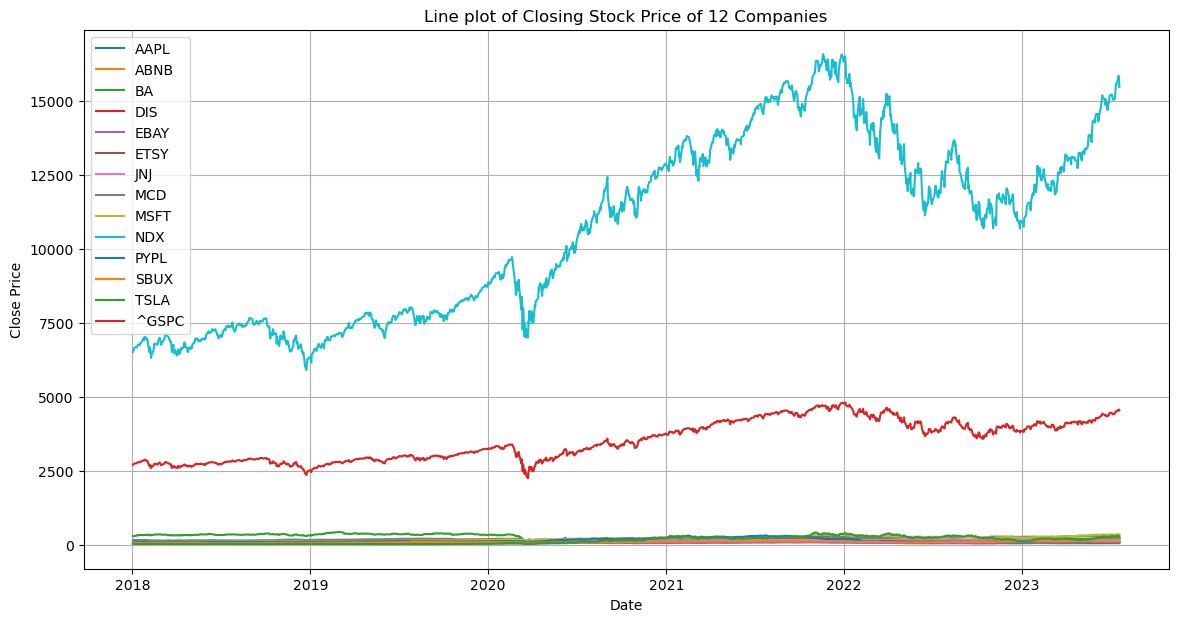

In [19]:
plt.figure(figsize=(14, 7))

# Plot each column
for ticker in stocks_adjclose:
    plt.plot(stocks_adjclose.index, stocks_adjclose[ticker], label=ticker)

# Add details to the plot
plt.title('Line plot of Closing Stock Price of 12 Companies')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Function to plot interactive plot
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df.index, y = df[i], name = i)
  fig.show()

In [21]:
interactive_plot(normalize(stocks_adjclose), 'Normalized Prices')

In [22]:
def daily_return(df):
  df_daily_return = df.copy()
  for i in df.columns[1:]:
        for j in range(1, len(df)):
            df_daily_return[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100
        df_daily_return[i][0] = 0
  return df_daily_return


In [24]:
stock_dailyreturns = daily_return(normalize(stocks_adjclose))

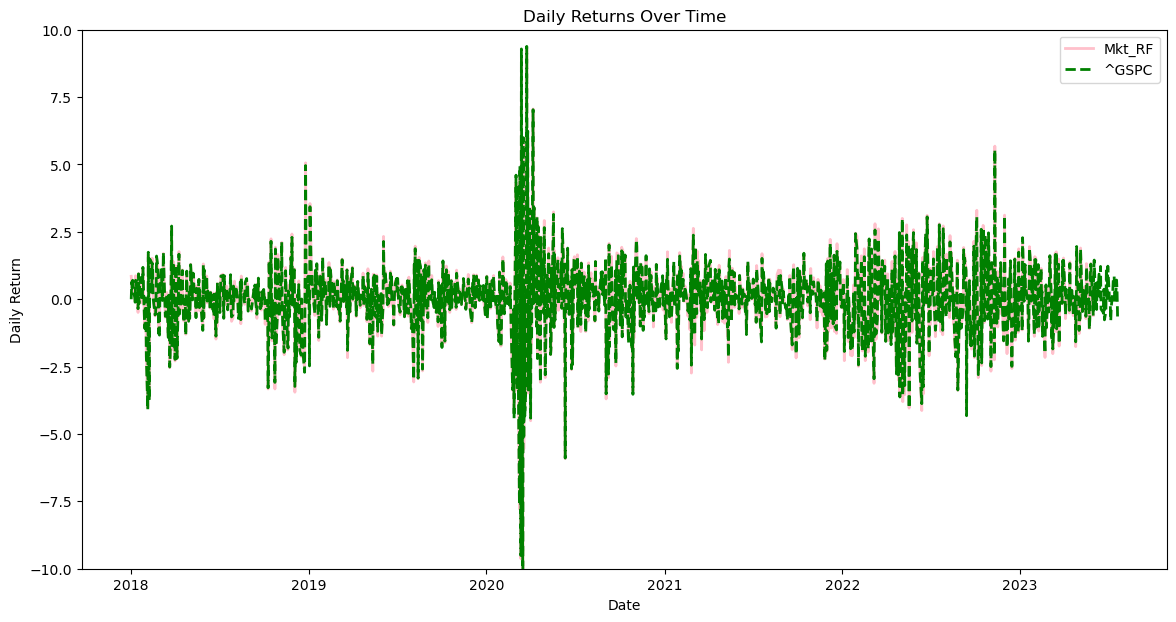

In [29]:
#Compare Daily Returns of Stocks and Market

fig, ax = plt.subplots(figsize=(14,7))

# List of dataframes and their corresponding labels
dfs= [market_return['Mkt_RF'],  stock_dailyreturns['^GSPC']]
labels = ['Mkt_RF', '^GSPC']
colors = ['pink', 'green']  # Set the colors for each line
linestyles = ['-', '--']  # Set the line styles

# Iterate through each dataframe and plot the daily returns
for df, label, color, linestyle in zip(dfs, labels, colors, linestyles):
    ax.plot(df.index, df, label=label, linewidth=2, color=color, linestyle=linestyle)


ax.set_ylim(-10, 10)

# Set the title and labels
ax.set_title('Daily Returns Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return')

# Show the legend
ax.legend()

# Show the plot
plt.show()

In [30]:
stock_dailyreturns = stock_dailyreturns.drop('ABNB', axis=1).loc['2018-01-02':'2023-05-31']

In [31]:
#Calculating Monthly Returns and Yearly Returns

def calc_monthly_returns(df):
    return df.pct_change().resample('M').mean()

def calc_annual_returns(df):
    return df.pct_change().resample('Y').mean()

stock_monthlyreturns = pd.DataFrame(calc_monthly_returns(stocks_adjclose))
stock_annualreturns = pd.DataFrame(calc_annual_returns(stocks_adjclose))
fund_monthlyreturns = pd.DataFrame(calc_monthly_returns(fund_adjclose))
fund_annualreturns = pd.DataFrame(calc_annual_returns(fund_adjclose))
market_monthlyreturns = pd.DataFrame(calc_monthly_returns(market_return['Mkt_RF']))
market_annualreturns = pd.DataFrame(calc_annual_returns(market_return['Mkt_RF']))

In [33]:
#Finding Excess Returns
def calc_excessreturns(df):
    df = df.sub(market_return['RF'], axis=0)
    return df

stock_excessreturns = pd.DataFrame(calc_excessreturns(stock_dailyreturns))

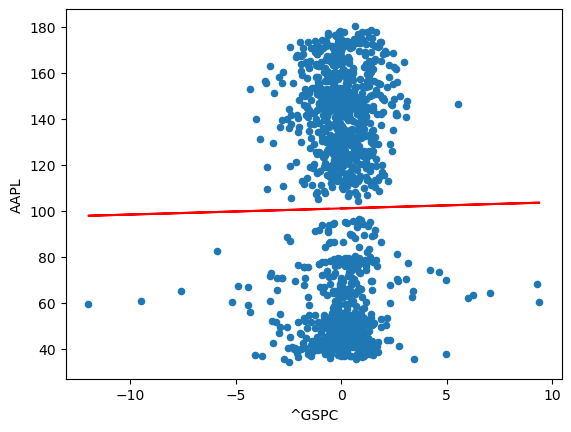

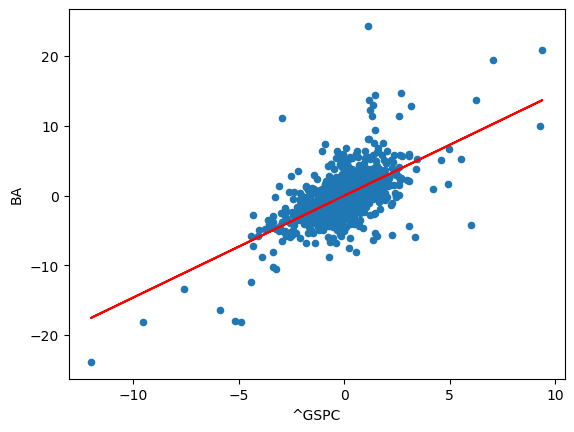

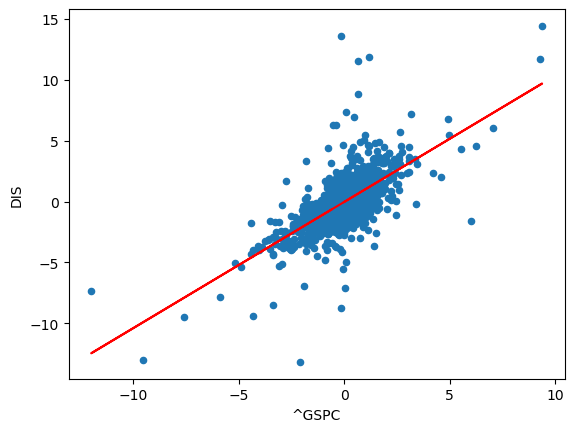

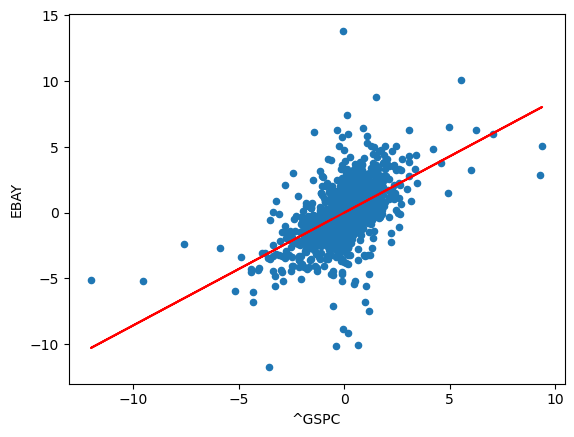

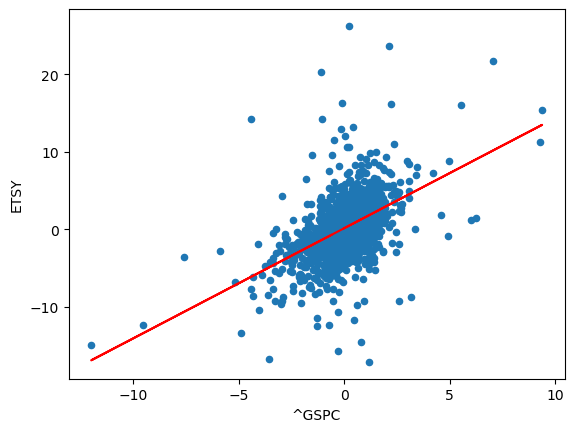

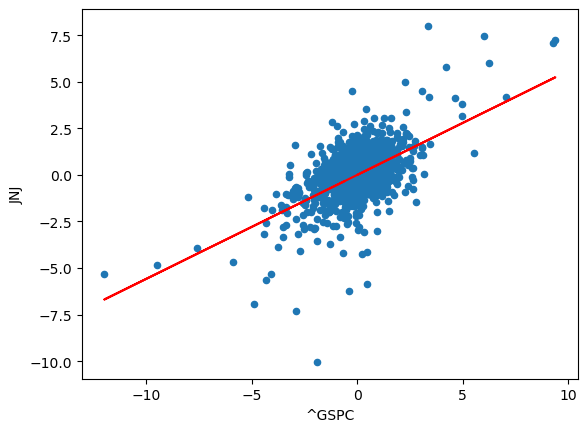

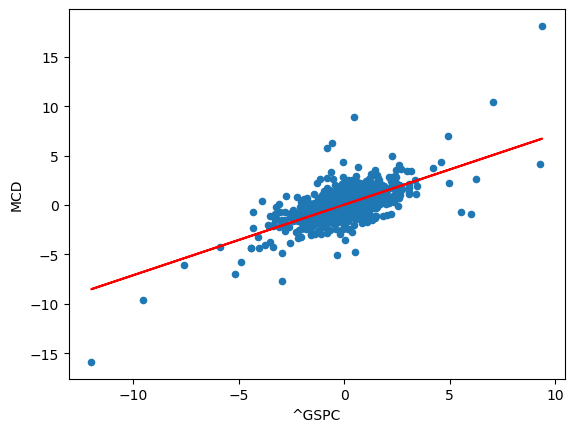

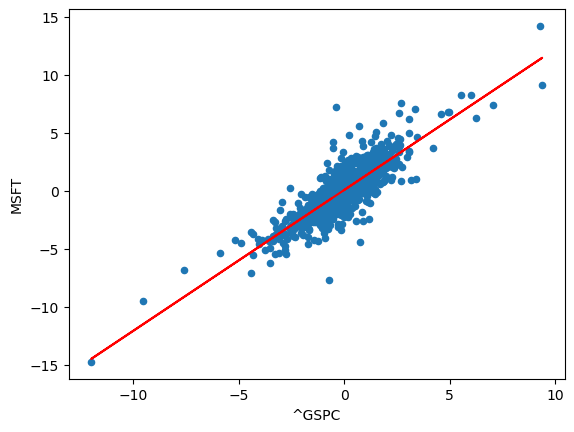

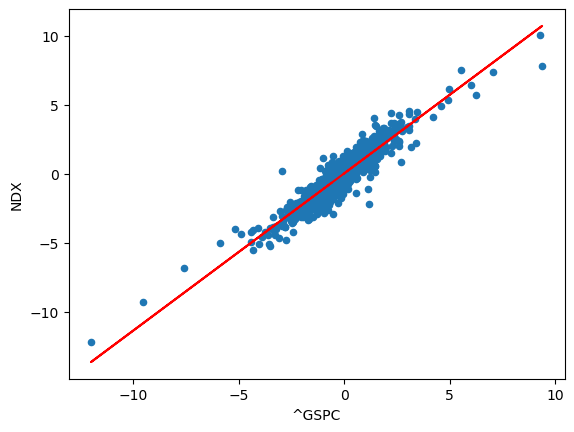

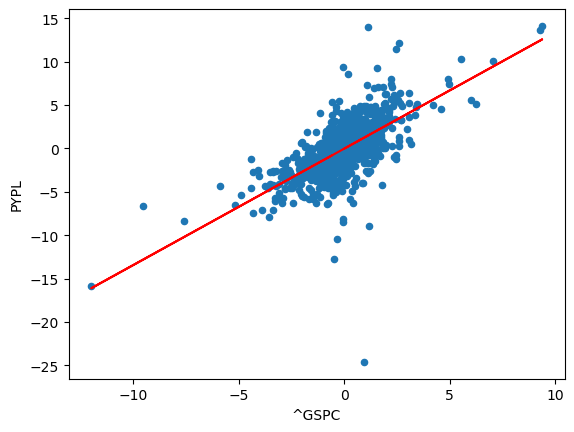

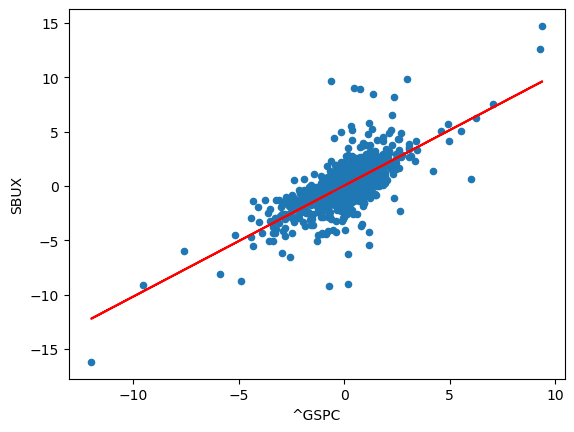

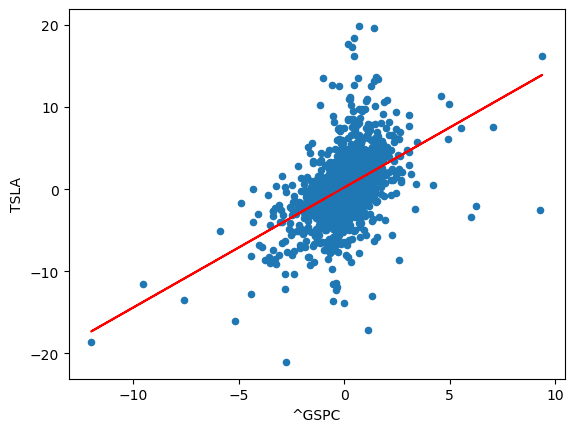

In [40]:
beta = {}
alpha = {}

for i in stock_dailyreturns.columns:
  if i != 'Date' and i != '^GSPC':
    stock_dailyreturns.plot(kind = 'scatter', x = '^GSPC', y = i)
    b, a = np.polyfit(stock_dailyreturns['^GSPC'], stock_dailyreturns[i], 1)
    plt.plot(stock_dailyreturns['^GSPC'], b * stock_dailyreturns['^GSPC'] + a, '-', color = 'r')  
    beta[i] = b    
    alpha[i] = a  
    plt.show()

In [47]:
#Calculating the beta of each stock

def calculate_beta(stock_dailyreturns, market_returns):
    covariance = stock_dailyreturns.cov(market_returns['Mkt_RF'])
    variance = market_returns['Mkt_RF'].var()
    beta = covariance / variance
    return beta

beta_AAPL = calculate_beta(stock_dailyreturns['AAPL'], market_return)
beta_TSLA = calculate_beta(stock_dailyreturns['TSLA'], market_return)
beta_BA = calculate_beta(stock_dailyreturns['BA'], market_return)
beta_MCD = calculate_beta(stock_dailyreturns['MCD'], market_return)
beta_MSFT = calculate_beta(stock_dailyreturns['MSFT'], market_return)
beta_SBUX = calculate_beta(stock_dailyreturns['SBUX'], market_return)
beta_EBAY = calculate_beta(stock_dailyreturns['EBAY'], market_return)
beta_ETSY = calculate_beta(stock_dailyreturns['ETSY'], market_return)
beta_DIS = calculate_beta(stock_dailyreturns['DIS'], market_return)
beta_PYPL = calculate_beta(stock_dailyreturns['PYPL'], market_return)
beta_JNJ = calculate_beta(stock_dailyreturns['JNJ'], market_return)
beta_GSPC = calculate_beta(stock_dailyreturns['^GSPC'], market_return)

calc_beta = pd.DataFrame([beta_AAPL, beta_TSLA, beta_BA, beta_MCD, beta_MSFT, beta_SBUX, beta_EBAY, beta_ETSY, beta_DIS, beta_PYPL, beta_JNJ, beta_GSPC], 
                         index=['AAPL', 'TSLA', 'BA', 'MCD', 'MSFT', 'SBUX', 'EBAY', 'ETSY', 'DIS', 'PYPL', 'JNJ', '^GSPC'], columns=['Beta'])


In [48]:
calc_beta.reset_index(inplace=True)
calc_beta.rename(columns={'index':'Ticker'}, inplace=True)

calc_beta

,Ticker,Beta
0,AAPL,0.138046
1,TSLA,1.514830
2,BA,1.443209
3,MCD,0.677808
4,MSFT,1.177706
5,SBUX,0.995032
6,EBAY,0.851899
7,ETSY,1.484128
8,DIS,1.019241
9,PYPL,1.350306


In [61]:
def calculate_capm_return(ticker, market_return):
    beta = calc_beta.loc[calc_beta['Ticker'] == ticker, 'Beta'].values[0]
    return market_return['RF'].mean() + (beta * (market_return['Mkt_RF'].mean() - market_return['RF'].mean()))

for ticker in calc_beta['Ticker']:
    print(f"The CAPM return for {ticker} is {calculate_capm_return(ticker, market_return)*100}%")

The CAPM return for AAPL is 1.136529420862563%
The CAPM return for TSLA is 5.888558578596648%
The CAPM return for BA is 5.641355644381636%
The CAPM return for MCD is 2.99954072857177%
The CAPM return for MSFT is 4.724961220286862%
The CAPM return for SBUX is 4.094454654698926%
The CAPM return for EBAY is 3.600424090676979%
The CAPM return for ETSY is 5.782588422919371%
The CAPM return for DIS is 4.178010595887109%
The CAPM return for PYPL is 5.320697294952971%
The CAPM return for JNJ is 2.436593721220573%
The CAPM return for ^GSPC is 4.017399384250505%


In [60]:
keys = calc_beta['Ticker'].tolist()

ER = {}

rf = market_return['RF'].mean() * 252
rm = market_return['Mkt_RF'].mean() * 252

for i in keys:
  beta_i = calc_beta.loc[calc_beta['Ticker'] == i, 'Beta'].values[0]
  ER[i] = rf + (beta_i * (rm - rf))
  print(f"The Expected Return based on CAPM for {i} is {ER[i]}%")

The Expected Return based on CAPM for AAPL is 2.864054140573659%
The Expected Return based on CAPM for TSLA is 14.839167618063552%
The Expected Return based on CAPM for BA is 14.216216223841721%
The Expected Return based on CAPM for MCD is 7.558842636000861%
The Expected Return based on CAPM for MSFT is 11.906902275122892%
The Expected Return based on CAPM for SBUX is 10.318025729841294%
The Expected Return based on CAPM for EBAY is 9.07306870850599%
The Expected Return based on CAPM for ETSY is 14.572122825756818%
The Expected Return based on CAPM for DIS is 10.528586701635515%
The Expected Return based on CAPM for PYPL is 13.408157183281487%
The Expected Return based on CAPM for JNJ is 6.140216177475844%
The Expected Return based on CAPM for ^GSPC is 10.123846448311275%


In [67]:
# Initialize an empty dictionary to hold your regression models
reg_models = {}

# Loop through each stock
for stock in stock_dailyreturns.columns:
    # Create a Linear Regression model
    reg = LinearRegression()

    # Reshape your data to the correct format
    X = market_return['Mkt_RF'].values.reshape(-1, 1)
    y = stock_dailyreturns[stock].values.reshape(-1, 1)

    # Fit the model
    reg.fit(X, y)

    # Store the model in your dictionary
    reg_models[stock] = reg
    
    # Print the coefficient and intercept
    print(f"For stock {stock}:")
    print(f"\tCoefficient (Beta): {reg.coef_[0][0]}")
    print(f"\tIntercept (Alpha): {reg.intercept_[0]}")

For stock AAPL:
	Coefficient (Beta): 0.13804575009887468
	Intercept (Alpha): 101.0177017485094
For stock BA:
	Coefficient (Beta): 1.4432091869065689
	Intercept (Alpha): -0.03408823654961647
For stock DIS:
	Coefficient (Beta): 1.019240678919004
	Intercept (Alpha): -0.03662941053051874
For stock EBAY:
	Coefficient (Beta): 0.8518990877477219
	Intercept (Alpha): -0.00023911786279385422
For stock ETSY:
	Coefficient (Beta): 1.4841279370381146
	Intercept (Alpha): 0.11630017859610517
For stock JNJ:
	Coefficient (Beta): 0.5147076469479726
	Intercept (Alpha): 0.005932042856257366
For stock MCD:
	Coefficient (Beta): 0.6778078009603807
	Intercept (Alpha): 0.028690067609805903
For stock MSFT:
	Coefficient (Beta): 1.1777062714381408
	Intercept (Alpha): 0.07373272804715482
For stock NDX:
	Coefficient (Beta): 1.121843248017945
	Intercept (Alpha): 0.024980570391510908
For stock PYPL:
	Coefficient (Beta): 1.350306257333746
	Intercept (Alpha): -0.03146907278361266
For stock SBUX:
	Coefficient (Beta): 0.9